<a href="https://colab.research.google.com/github/leonardoLavagna/Kaggle-Competition/blob/main/TrainingCampV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd

In [2]:
# Configuration
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
PATH = '/content/images'
BATCHES = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# to import the images on Google Colab execute the following command
# !git clone https://github.com/leonardoLavagna/Kaggle-Competition.git

In [4]:
# Function to load and tensorize all the images in the train folder
# The images are also augmented and normalized 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])
}

In [5]:
# Load the training images
# Try different batch sizes
training_dataset = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(training_dataset[x], batch_size=BATCHES,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(training_dataset[x]) for x in ['train']}
class_names = training_dataset['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# check
dataset_sizes

{'train': 2309}

In [7]:
# check
class_names

['battleships',
 'coast-guard',
 'containerships',
 'cruise-ships',
 'drilling-rigs',
 'motor-yachts',
 'submarines']

In [8]:
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [9]:
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        phase = 'train'
        
        scheduler.step() # after optimizer step?
        model.train()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            with torch.set_grad_enabled(phase == phase):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward pass
              loss.backward()
              optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Suggestion: use a GPU

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
# Try other optimizers 
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
# Try other settings
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)       


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)        


Epoch 1/25
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 1.2869 Acc: 0.5747

Epoch 2/25
----------
train Loss: 1.0681 Acc: 0.6297

Epoch 3/25
----------
train Loss: 0.9332 Acc: 0.6765

Epoch 4/25
----------
train Loss: 0.8832 Acc: 0.6921

Epoch 5/25
----------
train Loss: 0.8587 Acc: 0.7042

Epoch 6/25
----------
train Loss: 0.8678 Acc: 0.6981

Epoch 7/25
----------
train Loss: 0.6612 Acc: 0.7700

Epoch 8/25
----------
train Loss: 0.5741 Acc: 0.7917

Epoch 9/25
----------
train Loss: 0.5714 Acc: 0.7999

Epoch 10/25
----------
train Loss: 0.5522 Acc: 0.7999

Epoch 11/25
----------
train Loss: 0.4996 Acc: 0.8216

Epoch 12/25
----------
train Loss: 0.5118 Acc: 0.8207

Epoch 13/25
----------
train Loss: 0.4614 Acc: 0.8328

Epoch 14/25
----------
train Loss: 0.4597 Acc: 0.8398

Epoch 15/25
----------
train Loss: 0.4630 Acc: 0.8359

Epoch 16/25
----------
train Loss: 0.4448 Acc: 0.8333

Epoch 17/25
----------
train Loss: 0.4618 Acc: 0.8333

Epoch 18/25
----------
train Loss: 0.4631 Acc: 0.8302

Epoch 19/25
----------
train Loss: 0.4459

In [13]:
# Next steps: 
# 1) find a better way to upload the data 
# 2) create evaluation data (val folder for the val phase in the model)
# 3) find a way to get the name of the classified images (needed for the submission of the csv file)
# 4) plots (train & validation losses, accurcaies,...)
# 5) test the accuracy with test data
# 6) get confusion matrix for tested data

In [14]:
# 2) 
import torch.utils.data as data
n = len(training_dataset)  
n_test = int(0.2 * n)  
test_set = torch.utils.data.Subset(training_dataset, range(n_test))  
train_set = torch.utils.data.Subset(training_dataset, range(n_test, n)) 
# then... ?

tensor([[[0.7725, 0.7725, 0.7765,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7765, 0.7765,  ..., 0.7765, 0.7765, 0.7804],
         [0.7804, 0.7804, 0.7804,  ..., 0.7725, 0.7725, 0.7725],
         ...,
         [0.5843, 0.5804, 0.5647,  ..., 0.6588, 0.6627, 0.6275],
         [0.6784, 0.7373, 0.7608,  ..., 0.6863, 0.6157, 0.5569],
         [0.5843, 0.6667, 0.7020,  ..., 0.6039, 0.6157, 0.7373]]])

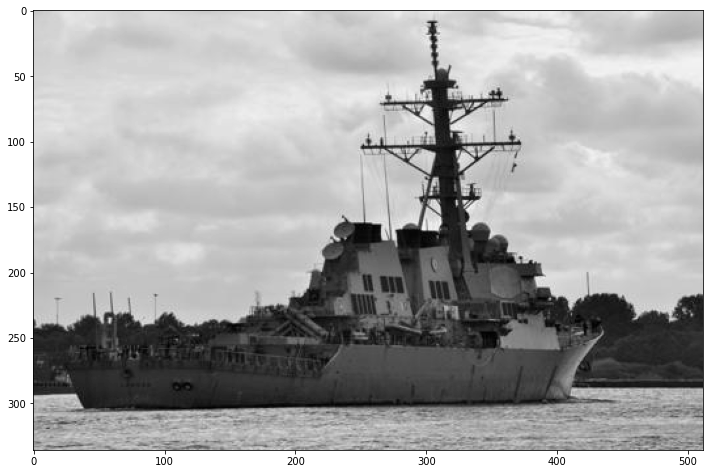

In [15]:
# Import a single gray scale image and tensorize it
import cv2

def display(img, cmap="gray"):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")

img1 = cv2.imread("/content/images/train/battleships/00012f15.jpg", 0)
display(img1)

# tensorization
transform=ToTensor()
transform(img1)